## 1) Histogram Computation

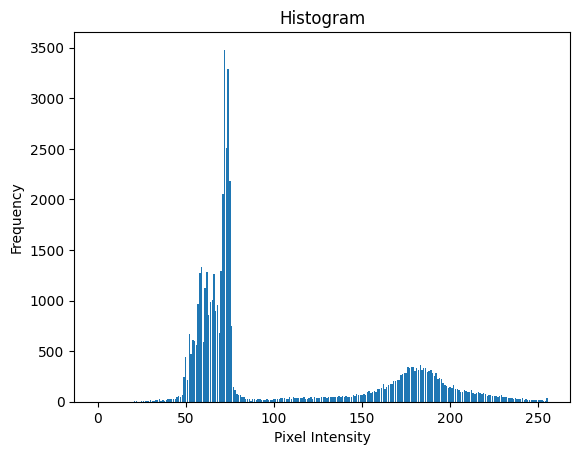

Average intensity from histogram: 103.30500158906722
Actual average intensity: 103.30500158906722


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def histogram(image_path):
    # Open the image and convert to grayscale
    img = Image.open(image_path).convert('L')
    
    # Convert the image to a numpy array for easier pixel access
    img_data = np.array(img)
    
    # Create an array of zeros for the histogram (one for each intensity level)
    hist = np.zeros(256)

    # Populate the histogram
    for i in range(img_data.shape[0]):
        for j in range(img_data.shape[1]):
            hist[img_data[i,j]] += 1
    
    return hist

# Load the image and compute the histogram
image_path = "images/coins.png"
hist = histogram(image_path)

# Plot the histogram
plt.bar(range(256), hist)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

# Compute the average intensity using the histogram
average_intensity = sum([i * hist[i] for i in range(256)]) / sum(hist)
print(f"Average intensity from histogram: {average_intensity}")

# Verify with the actual average intensity
img = Image.open(image_path).convert('L')
img_data = np.array(img)
actual_avg_intensity = np.mean(img_data)
print(f"Actual average intensity: {actual_avg_intensity}")


## 2) Otsu’s Binarization

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time  #  Import the time module

def binarize(img_data, t):
    # All pixels less than the threshold will be black (0), otherwise white (255)
    return np.where(img_data < t, 0, 255)



def within_class_variance(img_data, t):
    # Pixels for both classes
    c1 = img_data[img_data < t]
    c2 = img_data[img_data >= t]
    
    # Probabilities of both classes
    p1 = len(c1) / (len(c1) + len(c2))
    p2 = len(c2) / (len(c1) + len(c2))
    
    
    if len(c1) == 0 or len(c2) == 0:  # To handle empty classes
        return np.inf
        
    # Variances of both classes
    var1 = np.var(c1)
    var2 = np.var(c2)
    
    # Within-class variance
    sigma_w2 = p1 * var1 + p2 * var2  # Expectation
    
    return sigma_w2

# def between_class_variance(img_data, t):
#     total_variance = np.var(img_data)
#     sigma_w2 = within_class_variance(img_data, t)
#     sigma_b2 = total_variance - sigma_w2
#     return sigma_b2

# standard way
def between_class_variance(img_data, t):
    c1 = img_data[img_data < t]
    c2 = img_data[img_data >= t]
    
    if len(c1) == 0 or len(c2) == 0:  # Handle empty classes
        return 0

    mu1 = np.mean(c1)
    mu2 = np.mean(c2)
    muT = np.mean(img_data)

    p1 = len(c1) / img_data.size
    p2 = len(c2) / img_data.size

    sigma_b2 = p1 * (mu1 - muT)**2 + p2 * (mu2 - muT)**2   #  E((x-muT)**2), distance from muT max
    return sigma_b2




In [2]:
# Load the image and convert to grayscale
img = Image.open("images/coins.png").convert('L')
img_data = np.array(img)


# Find the optimal threshold
thresholds = np.arange(0, 256)

# Time the computation for minimizing within-class variance
start_time = time.time()
within_class_variances = [within_class_variance(img_data, t) for t in thresholds]
optimal_t_w = np.argmin(within_class_variances)
duration_within_class = time.time() - start_time

# Time the computation for maximizing between-class variance
start_time = time.time()
between_class_variances = [between_class_variance(img_data, t) for t in thresholds]
optimal_t_b = np.argmax(between_class_variances)
duration_between_class = time.time() - start_time

print(f"Optimal threshold by minimizing within-class variance: {optimal_t_w}")
print(f"Time taken for minimizing within-class variance: {duration_within_class:.4f} seconds")
print('\n')
print(f"Optimal threshold by maximizing between-class variance: {optimal_t_b}")
print(f"Time taken for maximizing between-class variance: {duration_between_class:.4f} seconds")

# Verification
assert optimal_t_w == optimal_t_b, "\nThe methods are not equivalent"
print("\nBoth methods are equivalent.")

Optimal threshold by minimizing within-class variance: 126
Time taken for minimizing within-class variance: 0.0710 seconds


Optimal threshold by maximizing between-class variance: 126
Time taken for maximizing between-class variance: 0.0500 seconds

Both methods are equivalent.


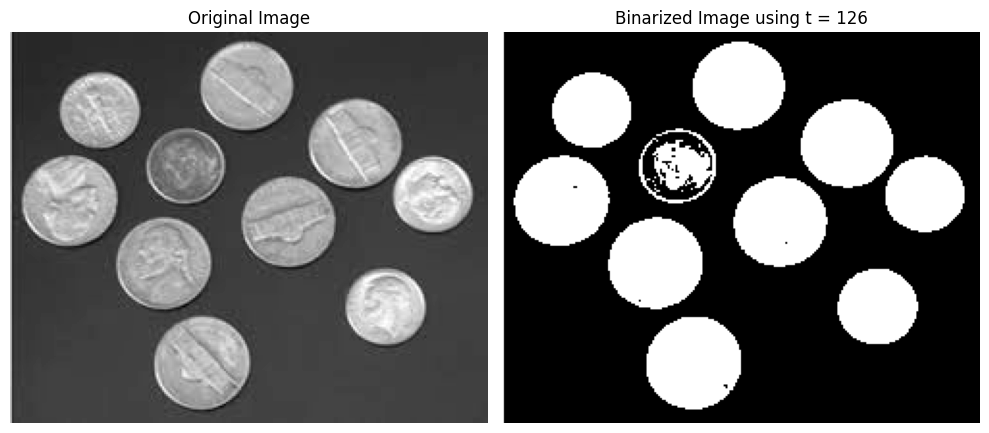

In [3]:
# Binarize the image using the optimal threshold
binarized_image_data = binarize(img_data, optimal_t_w)  # or optimal_t_b, they are equivalent


# Set up a plot with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')  # to hide axis labels

# Display the binarized image
axes[1].imshow(binarized_image_data, cmap='gray')
axes[1].set_title(f"Binarized Image using t = {optimal_t_w}")
axes[1].axis('off')  # to hide axis labels

# Show both images
plt.tight_layout()
plt.show()

## 3) Depth based Extraction

Optimal Threshold by Otsu Method (Between Class Variance) for Binarization: 144.0


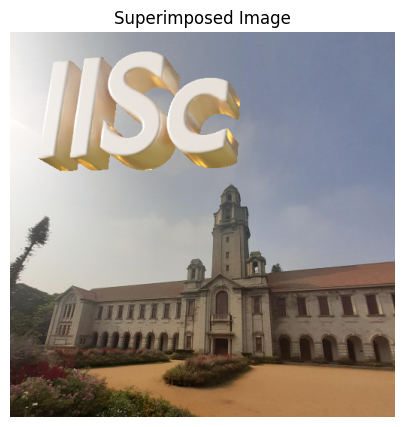

In [4]:

import numpy as np
from matplotlib import image
import matplotlib.pyplot as plt

# Function to binarize an image based on a given threshold
def binarize(image, threshold):     # depthImg : grayscale
    # Create a new array to store the binarized image, initially a copy of the original
    binaryImage = np.array(image, copy=True)
    
    # Iterate over each pixel in the image
    for rowIndex, colV in enumerate(image):
        for colIndex, value in enumerate(colV):
            # If pixel value is greater than threshold, set to 1; otherwise set to 0
            binaryImage[rowIndex][colIndex] = 0 if value < threshold else 1
            
    return binaryImage  # Return the binarized image

# Function to superimpose text from a depth map onto a background image
def imageSuperImpose(textImage, depthImage, backgroundImage, threshold):
    # Binarize the depth image based on the threshold
    binarizedImage = binarize(depthImage, threshold)
    
    # Create a new array to store the final superimposed image, initially a copy of the background
    overlappedImage = np.array(backgroundImage, copy=True)
    
    # Iterate over each pixel in the binarized depth image
    for rowIndex, colV in enumerate(binarizedImage):
        for colIndex, value in enumerate(colV):
            # If binarized pixel is 1, replace with text; otherwise keep the background pixel
            #if value == 1:  # 1: white/bright, 0: black/dark
            # below operation updates all three channels (R, G, and B) at once since 
            # overlappedImage[rowIndex][colIndex] and textImage[rowIndex][colIndex] are 3-element arrays (representing RGB values).
            overlappedImage[rowIndex][colIndex] = textImage[rowIndex][colIndex] if value == 1 else overlappedImage[rowIndex][colIndex]
            
    return overlappedImage  # Return the superimposed image


# Paths to images
depthImage = image.imread('images/IIScTextDepth.png')   #  Grayscale image, matplotlib imread, normalized pixels between 0 & 1 
textImage = image.imread('images/IIScText.png')
backgroundImage = image.imread('images/IIScMainBuilding.png')


# Find the optimal threshold
thresholds = np.arange(0, 256)/255.0 # normalized thresholds

# within_class_variances = [within_class_variance(depthImage, t) for t in thresholds]  # matplotlib imread
# optimal_t_w = np.argmin(within_class_variances)
# optimal_t_w = optimal_t_w/255.0
# print("Optimal Threshold by Otsu Method (Within Class Variance) for Binarization:", optimal_t_w *255.0)


between_class_variances = [between_class_variance(depthImage, t) for t in thresholds]
optimal_t_b = np.argmax(between_class_variances)
optimal_t_b = optimal_t_b/255.0
print("Optimal Threshold by Otsu Method (Between Class Variance) for Binarization:", optimal_t_b * 255.0)

result_image = imageSuperImpose(textImage,depthImage,backgroundImage,optimal_t_b)

#result_image = imageSuperImpose(textImage,depthImage,backgroundImage,optimal_t_w)

# Using matplotlib to display the resulting image
plt.figure(figsize=(5,5))
plt.imshow(result_image)
plt.axis('off')
plt.title('Superimposed Image')
plt.show()

# plt.imshow(result_image)
# plt.savefig("q3Output.png")
# plt.show()


## 4) Connected Components

In [33]:
import numpy as np
from matplotlib import image
import matplotlib.pyplot as plt


# Image Binarization using a given specific threshold
def binarize(image,threshold):
    binaryImage = np.array(image, copy=True)
    for rowIndex, colV in enumerate(image):
        for colIndex, value in enumerate(colV):
            binaryImage[rowIndex][colIndex] = 0 if value < threshold else 1
    return binaryImage


# Gives the Min Label Value In the Region
def minLabelInTheRegion(rowVal, colVal, labelImage,region):
    newLabel = None
    labels = set()
    for x,y in region:
        nRow = rowVal + x
        nCol = colVal + y
        if nRow >= 0 and nRow < labelImage.shape[0] and nCol >=0 and nCol < labelImage.shape[1] and labelImage[nRow][nCol] != 0:  # if any label(not 0)
            newLabel = labelImage[nRow][nCol] if newLabel is None else min(labelImage[nRow][nCol],newLabel)  # check all for 8 neighbours
            labels.add(labelImage[nRow][nCol])
    return newLabel, labels   # returns None if all surrounding 8 pixels are 0.



# Combines equivalence sets
def combineEquivalenceSet(equivalenceDict,minLabel,labels):
    finalUnion = set()
    for label in labels:
        finalUnion = finalUnion.union(equivalenceDict[label])
    for label in finalUnion:
        equivalenceDict[label]= finalUnion
    return equivalenceDict

In [34]:
def connectedComponentAnalysis(image,threshold):
    region = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(-1,1),(1,-1),(-1,-1)]
    binaryImage = binarize(image,threshold)
    labelImage = np.zeros(binaryImage.shape)  # black
    newLabel = 1
    equivalenceDict = {}
    
    # First pass where we iterate and give the min label and construct the equivalence set.
    for rowIndex, colV in enumerate(binaryImage):
        for colIndex, value in enumerate(colV):
            if value == 0:  # here foreground is black/dark   ,  value == 1: not a CC.
                # Get the minLabel in the Region
                minLabel, labels = minLabelInTheRegion(rowIndex,colIndex,labelImage,region)
                if minLabel is not None :  # neighbourhood pixels has a label
                    equivalenceDict = combineEquivalenceSet(equivalenceDict,minLabel,labels)
                    labelImage[rowIndex][colIndex] = minLabel
                else:       # neighbourhood pixels has no label (0: black)
                    labelImage[rowIndex][colIndex] = newLabel
                    equivalenceDict[newLabel] = set([newLabel])  # equivalent labels set for each label
                    newLabel += 1
  
    # Second pass where we iterate and flood the connected regions with the minValue in the equivalence set
    for rowIndex, colV in enumerate(labelImage):
        for colIndex, value in enumerate(colV):
            if value != 0:   # value: labels (not 0 : not black blackground)
                labelImage[rowIndex][colIndex] = min(equivalenceDict[value])  # replace with min label
                
    # Now, let's get the labels and the number of pixels for each label, then we can filter with a threshold to remove the punctuations.
    labelToCharacters = {}
    for rowIndex, colV in enumerate(labelImage):
        for colIndex, value in enumerate(colV):
            if value != 0:   # value: labels
                labelToCharacters[value] = 1 if labelToCharacters.get(value) is None else labelToCharacters[value] + 1  #labelToCharacters.get(value) + 1

    # visualize
    plt.imshow(binaryImage, cmap='gray')
    plt.title("Binarized Image")
    plt.show()

    plt.imshow(labelImage)
    plt.title("Labeled Image")
    plt.colorbar()
    plt.show()

    
    # Filter the punctuations with pixelCount
    totalCharacters =0
    for label in labelToCharacters.keys():    # K
        pixelCount = labelToCharacters.get(label)    # V
        if pixelCount > 60:
            totalCharacters +=1    
    return totalCharacters


Optimal Threshold by Otsu Method (Within Class Variance) for Binarization: 143.0


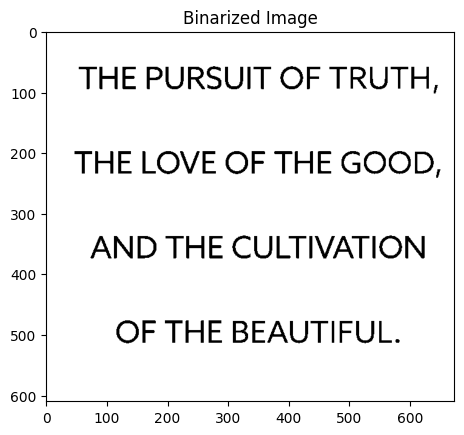

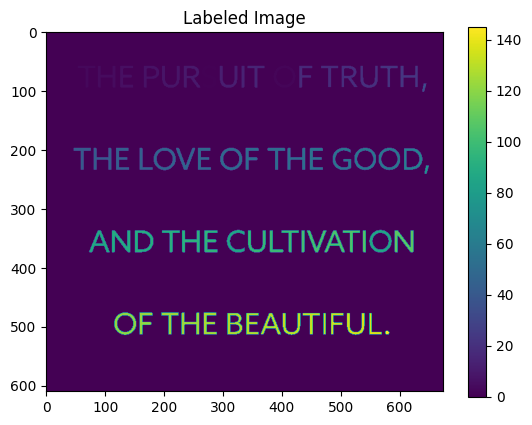



Number of characters: 64


In [35]:
# Load the image
quoteImage = image.imread('images/quote.png')


# Find the optimal threshold
thresholds = np.arange(0, 256)/255.0 # normalized thresholds

within_class_variances = [within_class_variance(quoteImage, t) for t in thresholds]  # matplotlib imread
optimal_t_w = np.argmin(within_class_variances)
optimal_t_w = optimal_t_w/255.0
print("Optimal Threshold by Otsu Method (Within Class Variance) for Binarization:", optimal_t_w *255.0)


# between_class_variances = [between_class_variance(quoteImage, t) for t in thresholds]
# optimal_t_b = np.argmax(between_class_variances)
# optimal_t_b = optimal_t_b/255.0
# print("Optimal Threshold by Otsu Method (Between Class Variance) for Binarization:", optimal_t_b * 255.0)



# Call the function on the provided image
print(f"\n\nNumber of characters: {connectedComponentAnalysis(quoteImage, optimal_t_w )}")

#print(f"\n\nNumber of characters: {connectedComponentAnalysis(quoteImage, optimal_t_b )}")



## 5) MSER (optional)